* https://www.sighthound.com/products/cloud
* https://www.sighthound.com/docs/cloud/detection/

5,000 API Calls (per month?) on developer tier

In [1]:
import requests
import os
import io
import base64
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image, ImageDraw, ImageFont
%matplotlib inline
import sys
print(sys.version)
from typing import Union, List, Set, Dict, Tuple

ATTR_GENDER_CONFIDENCE = 'gender_confidence'
ATTR_PERSONS = 'persons'
ATTR_TOTAL_PERSONS = 'total_persons'
ATTR_AGE = 'age'
ATTR_CONFIDENCE = 'confidence'
ATTR_FACES = 'faces'
ATTR_GENDER = 'gender'
ATTR_TOTAL_FACES = 'total_faces'
ATTR_BOUNDING_BOX = 'bounding_box'
ATTR_IMAGE_ID = 'image_id'
TIMEOUT = 9
HTTP_OK = 200

def load_api_secrets(filename):
    """Convenience to load the API key from a json file."""
    try:
        with open(filename, 'r') as fp:
            api_params = json.load(fp)
    except Exception as e:
        print('Failed to load API secrets key: {}'.format(e))
        api_params = None
    return api_params['key']

    
def encode_image(image : bytes) -> str:
    """base64 encode an image."""
    return base64.b64encode(image).decode('ascii')

def parse_api_response(response):
    """Parse the response from the API. """
    faces = []
    persons = []
    for obj in response.json()['objects']:
        if obj['type'] == 'face':
            faces.append(obj)
        if obj['type'] == 'person':
            persons.append(obj)
    return faces, persons

def parse_faces(api_faces):
    """Parse the API face data into the format required."""
    known_faces = []
    for entry in api_faces:
        face = {}
        face[ATTR_GENDER] = entry['attributes']['gender']
        face[ATTR_AGE] = entry['attributes']['age']
        face[ATTR_BOUNDING_BOX] = entry['boundingBox']
        known_faces.append(face)
    return known_faces

3.7.3 (default, Mar 27 2019, 16:54:48) 
[Clang 4.0.1 (tags/RELEASE_401/final)]


In [2]:
encode_image(b"Test")

'VGVzdA=='

In [3]:
api_key_file_path = '/Users/robin/Documents/Sighthound_API_key.json'
api_key = load_api_secrets(api_key_file_path)

In [4]:
headers = {"Content-type": "application/json",
           "X-Access-Token": api_key}

In [5]:
image_file_path = 'people_car.jpg'

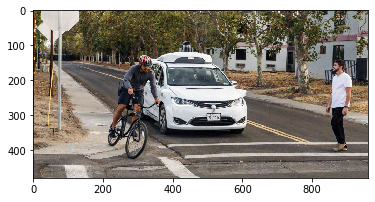

In [6]:
img = plt.imread(image_file_path)  # Creates an ndarray
plt.imshow(img)
plt.show()

In [7]:
class SimplehoundException(Exception):
    pass

In [8]:
with open(image_file_path, "rb") as img_bytes:
    image_data = encode_image(img_bytes.read()) 

In [9]:
url = 'https://dev.sighthoundapi.com/v1/detections'

In [10]:
params = (
    ('type', 'all'),
    ('faceOption', 'gender,age'),
)


In [11]:
%%time

response = requests.post('https://dev.sighthoundapi.com/v1/detections', 
                        headers=headers, 
                        params=params, 
                        data=json.dumps({"image": image_data}))

CPU times: user 26.1 ms, sys: 8.23 ms, total: 34.3 ms
Wall time: 1.28 s


In [12]:
response.status_code

200

In [13]:
if not response.status_code == HTTP_OK:
    print(response.status_code)

In [14]:
assert response.status_code == 200

In [15]:
response.status_code

200

In [16]:
response.reason

'OK'

In [17]:
response.json()

{'image': {'width': 960, 'height': 480, 'orientation': 1},
 'objects': [{'type': 'face',
   'boundingBox': {'x': 305, 'y': 151, 'height': 28, 'width': 30},
   'attributes': {'gender': 'male',
    'genderConfidence': 0.9733,
    'age': 33,
    'ageConfidence': 0.7801,
    'frontal': True}},
  {'type': 'face',
   'boundingBox': {'x': 855, 'y': 147, 'height': 29, 'width': 24},
   'attributes': {'gender': 'male',
    'genderConfidence': 0.9834,
    'age': 37,
    'ageConfidence': 0.5096,
    'frontal': False}},
  {'type': 'person',
   'boundingBox': {'x': 227, 'y': 133, 'height': 245, 'width': 125}},
  {'type': 'person',
   'boundingBox': {'x': 833, 'y': 137, 'height': 268, 'width': 93}}],
 'requestId': '79b11796499b4823a77b30c28a376456'}

In [18]:
len(response.json()['objects'])

4

In [19]:
persons = []
faces = []

for obj in response.json()['objects']:
    print(obj['type'])
    if obj['type'] == 'person':
        persons.append(obj)    
    if obj['type'] == 'face':
        faces.append(obj)

face
face
person
person


In [20]:
faces, persons = parse_api_response(response)

In [21]:
len(faces)

2

In [22]:
len(persons)

2

In [23]:
persons[0]

{'type': 'person',
 'boundingBox': {'x': 227, 'y': 133, 'height': 245, 'width': 125}}

In [24]:
response.json()['objects'][0]['attributes']['gender']

'male'

In [25]:
bounding_box  = response.json()['objects'][0]['boundingBox']
bounding_box

{'x': 305, 'y': 151, 'height': 28, 'width': 30}

In [26]:
parse_faces(faces)

[{'gender': 'male',
  'age': 33,
  'bounding_box': {'x': 305, 'y': 151, 'height': 28, 'width': 30}},
 {'gender': 'male',
  'age': 37,
  'bounding_box': {'x': 855, 'y': 147, 'height': 29, 'width': 24}}]

## Tensorflow box
The box returned by Sighthound differs from the Tensorflow standard, described below:

    The bounding box is defined by the tuple (y_min, x_min, y_max, x_max)
    where the coordinates are floats in the range [0.0, 1.0] and
    relative to the width and height of the image.
    For example, if an image is 100 x 200 pixels (height x width) and the bounding
    box is `(0.1, 0.2, 0.5, 0.9)`, the upper-left and bottom-right coordinates of
    the bounding box will be `(40, 10)` to `(180, 50)` (in (x,y) coordinates).

In [27]:
hound_bbox = persons[0]['boundingBox']
hound_bbox

{'x': 227, 'y': 133, 'height': 245, 'width': 125}

In [28]:
def bbox_to_tf_style(bbox : Dict, img_width : int, img_height : int) -> Tuple:
    """Convert Sighthound bounding box to tensorflow box style."""
    decimals = 5
    x_min = round(bbox['x'] / img_width, decimals)
    x_max = round((bbox['x'] + bbox['width']) / img_width, decimals)
    y_min = round(bbox['y'] / img_height, decimals)
    y_max = round((bbox['y'] + bbox['height']) / img_height, decimals)
    return (y_min, x_min, y_max, x_max)

bbox = {'x': 227, 'y': 133, 'height': 245, 'width': 125}
img_width = 960
img_height = 480
tf_bbox = bbox_to_tf_style(bbox, img_width, img_height)
tf_bbox

(0.27708, 0.23646, 0.7875, 0.36667)

In [29]:
def draw_box(
    draw: ImageDraw,
    box: Tuple[float, float, float, float],
    img_width: int,
    img_height: int,
    text: str = "",
    color: Tuple[int, int, int] = (255, 255, 0),
) -> None:
    """
    Draw a bounding box on and image.
    The bounding box is defined by the tuple (y_min, x_min, y_max, x_max)
    where the coordinates are floats in the range [0.0, 1.0] and
    relative to the width and height of the image.
    For example, if an image is 100 x 200 pixels (height x width) and the bounding
    box is `(0.1, 0.2, 0.5, 0.9)`, the upper-left and bottom-right coordinates of
    the bounding box will be `(40, 10)` to `(180, 50)` (in (x,y) coordinates).
    """

    line_width = 3
    font_height = 8
    y_min, x_min, y_max, x_max = box
    (left, right, top, bottom) = (
        x_min * img_width,
        x_max * img_width,
        y_min * img_height,
        y_max * img_height,
    )
    draw.line(
        [(left, top), (left, bottom), (right, bottom), (right, top), (left, top)],
        width=line_width,
        fill=color,
    )
    if text:
        draw.text(
            (left + line_width, abs(top - line_width - font_height)), text, fill=color
        )

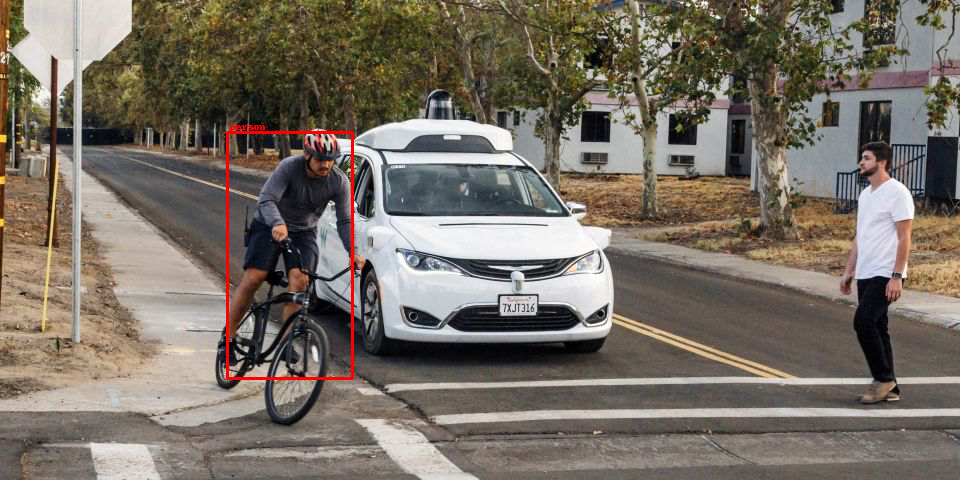

In [30]:
img = Image.open(image_file_path)
draw = ImageDraw.Draw(img)

red=(255, 0, 0)
draw_box(draw, tf_bbox, img_width, img_height, text="person", color=red)

img